<a href="https://colab.research.google.com/github/TaherLilywala/MIDAS-Task-NLP/blob/main/MIDAS_NLP_Task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Loading Data

Loading the Data and having a look at the basic structure

In [646]:
# Importing relevant libraries

import pandas as pd
import numpy as np
import tensorflow as tf
import os
import math
import cv2

import pickle

import matplotlib.pyplot as plt
from io import StringIO
import pandas as pd
from collections import Counter
import string
import os
import gensim
from spacy.matcher import PhraseMatcher
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
from textblob import TextBlob, Word
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [647]:
#Loading data onto a DataFrame

from google.colab import drive
drive.mount('/content/drive')
df=pd.read_csv('/content/drive/My Drive/Miscellaneous DL/MIDAS Task 3/flipkart-data.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [648]:
df.head(5)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,c2d766ca982eca8304150849735ffef9,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2FF9KEDEFGF,999.0,379.0,"[""http://img5a.flixcart.com/image/short/u/4/a/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
1,7f7036a6d550aaa89d34c77bd39a5e48,2016-03-25 22:59:23 +0000,http://www.flipkart.com/fabhomedecor-fabric-do...,FabHomeDecor Fabric Double Sofa Bed,"[""Furniture >> Living Room Furniture >> Sofa B...",SBEEH3QGU7MFYJFY,32157.0,22646.0,"[""http://img6a.flixcart.com/image/sofa-bed/j/f...",False,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,No rating available,No rating available,FabHomeDecor,"{""product_specification""=>[{""key""=>""Installati..."
2,f449ec65dcbc041b6ae5e6a32717d01b,2016-03-25 22:59:23 +0000,http://www.flipkart.com/aw-bellies/p/itmeh4grg...,AW Bellies,"[""Footwear >> Women's Footwear >> Ballerinas >...",SHOEH4GRSUBJGZXE,999.0,499.0,"[""http://img5a.flixcart.com/image/shoe/7/z/z/r...",False,Key Features of AW Bellies Sandals Wedges Heel...,No rating available,No rating available,AW,"{""product_specification""=>[{""key""=>""Ideal For""..."
3,0973b37acd0c664e3de26e97e5571454,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2F6HUZMQ6SJ,699.0,267.0,"[""http://img5a.flixcart.com/image/short/6/2/h/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
4,bc940ea42ee6bef5ac7cea3fb5cfbee7,2016-03-25 22:59:23 +0000,http://www.flipkart.com/sicons-all-purpose-arn...,Sicons All Purpose Arnica Dog Shampoo,"[""Pet Supplies >> Grooming >> Skin & Coat Care...",PSOEH3ZYDMSYARJ5,220.0,210.0,"[""http://img5a.flixcart.com/image/pet-shampoo/...",False,Specifications of Sicons All Purpose Arnica Do...,No rating available,No rating available,Sicons,"{""product_specification""=>[{""key""=>""Pet Type"",..."


In [649]:
df.shape

(20000, 15)

##Cleaning Data

Standard NLP Text Pre-Processing, to make the input data more workable.

In [650]:
def clean_data(hd_df, col_name):

    # Converting to lower case
    hd_df[col_name] = hd_df[col_name].apply(lambda x: " ".join(x.lower() for x in x.split()))

    # Removing tags
    hd_df[col_name] = hd_df[col_name].str.replace('<.*?>','')

    # Removing possible mentions or urls
    hd_df[col_name] = hd_df[col_name].str.replace('@\w+','')
    hd_df[col_name] = hd_df[col_name].str.replace('http.?://[^\s]+[\s]?','')

    # Removing punctuation and symbols
    hd_df[col_name] = hd_df[col_name].str.replace('[^\w\s]', '')
    hd_df[col_name] = hd_df[col_name].apply(lambda x: " ".join(y for y in x.split() if y not in string.punctuation))

    # Removing non alphabetical character
    hd_df[col_name] = hd_df[col_name].apply(lambda x: " ".join(y for y in x.split() if y.isalpha()))

    # Removing characters non longer than 1
    hd_df[col_name] = hd_df[col_name].apply(lambda x: " ".join(y for y in x.split() if len(y) > 1))

    # Removing stopwords
    sw = stopwords.words('english')
    hd_df[col_name] = hd_df[col_name].apply(lambda x: " ".join(y for y in x.split() if y not in sw))

    # Removing digits
    hd_df[col_name] = hd_df[col_name].apply(lambda x: " ".join(y for y in x.split() if not y.isdigit()))

    # Removing multiple spaces
    hd_df[col_name] = hd_df[col_name].str.replace(' +',' ')

    # Lemmatization 
    hd_df[col_name] = hd_df[col_name].apply(lambda x: " ".join([Word(w).lemmatize() for w in x.split()]))

    return hd_df

In [651]:
# only consider data where description is not null
df_new = df[df['description'].notnull()]
df_new = clean_data(df_new,'description')
#df_new = clean_data(df_new,'product_category_tree')
df_new.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,c2d766ca982eca8304150849735ffef9,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2FF9KEDEFGF,999.0,379.0,"[""http://img5a.flixcart.com/image/short/u/4/a/...",False,key feature alisha solid woman cycling short c...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
1,7f7036a6d550aaa89d34c77bd39a5e48,2016-03-25 22:59:23 +0000,http://www.flipkart.com/fabhomedecor-fabric-do...,FabHomeDecor Fabric Double Sofa Bed,"[""Furniture >> Living Room Furniture >> Sofa B...",SBEEH3QGU7MFYJFY,32157.0,22646.0,"[""http://img6a.flixcart.com/image/sofa-bed/j/f...",False,fabhomedecor fabric double sofa bed finish col...,No rating available,No rating available,FabHomeDecor,"{""product_specification""=>[{""key""=>""Installati..."
2,f449ec65dcbc041b6ae5e6a32717d01b,2016-03-25 22:59:23 +0000,http://www.flipkart.com/aw-bellies/p/itmeh4grg...,AW Bellies,"[""Footwear >> Women's Footwear >> Ballerinas >...",SHOEH4GRSUBJGZXE,999.0,499.0,"[""http://img5a.flixcart.com/image/shoe/7/z/z/r...",False,key feature aw belly sandal wedge heel casuals...,No rating available,No rating available,AW,"{""product_specification""=>[{""key""=>""Ideal For""..."
3,0973b37acd0c664e3de26e97e5571454,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2F6HUZMQ6SJ,699.0,267.0,"[""http://img5a.flixcart.com/image/short/6/2/h/...",False,key feature alisha solid woman cycling short c...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
4,bc940ea42ee6bef5ac7cea3fb5cfbee7,2016-03-25 22:59:23 +0000,http://www.flipkart.com/sicons-all-purpose-arn...,Sicons All Purpose Arnica Dog Shampoo,"[""Pet Supplies >> Grooming >> Skin & Coat Care...",PSOEH3ZYDMSYARJ5,220.0,210.0,"[""http://img5a.flixcart.com/image/pet-shampoo/...",False,specification sicons purpose arnica dog shampo...,No rating available,No rating available,Sicons,"{""product_specification""=>[{""key""=>""Pet Type"",..."


21330


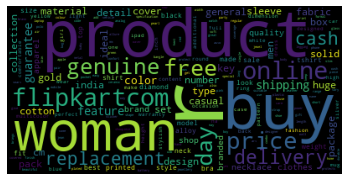

In [652]:
#function to split text into word
tokens = word_tokenize(df_new.description.str.cat(sep=' '))
vocabulary = set(tokens)
print(len(vocabulary))
frequency_dist = nltk.FreqDist(tokens)
# sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)

from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud().generate_from_frequencies(frequency_dist)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# also add stuff[maybe a simple print()] to show the state of words before and after cleaning

In [653]:
# Tokenizing inputs
desc = list()
lines  = df_new.description.values.tolist()

for i,line in enumerate(lines):
  tokens = word_tokenize(line)
  tokens = [w.lower() for w in tokens]
  table = str.maketrans('','',string.punctuation)
  stripped = [w.translate(table) for w in tokens]
  words = [word for word in stripped  if word.isalpha()]
  desc.append(words)

In [654]:
print(len(desc))
print(desc[0])
print(desc[1])

19998
['key', 'feature', 'alisha', 'solid', 'woman', 'cycling', 'short', 'cotton', 'lycra', 'navy', 'red', 'navyspecifications', 'alisha', 'solid', 'woman', 'cycling', 'short', 'short', 'detail', 'number', 'content', 'sale', 'package', 'pack', 'fabric', 'cotton', 'lycra', 'type', 'cycling', 'short', 'general', 'detail', 'pattern', 'solid', 'ideal', 'woman', 'fabric', 'care', 'gentle', 'machine', 'wash', 'lukewarm', 'water', 'bleach', 'additional', 'detail', 'style', 'code', 'box', 'short']
['fabhomedecor', 'fabric', 'double', 'sofa', 'bed', 'finish', 'color', 'leatherette', 'black', 'mechanism', 'type', 'pull', 'price', 'r', 'fine', 'deep', 'seating', 'experience', 'save', 'space', 'new', 'click', 'clack', 'sofa', 'bed', 'easy', 'fold', 'vice', 'versa', 'simple', 'click', 'clack', 'mechanism', 'chrome', 'leg', 'mango', 'wood', 'frame', 'long', 'term', 'durability', 'double', 'cushioned', 'sofa', 'bed', 'provide', 'extra', 'softness', 'make', 'fine', 'seating', 'experience', 'double', '

##Preparing Inputs

Tokenizing Product Description, Using a Label Encoder to encode the Categories to Feed the Model.

In [655]:
#Using Bag Of Words over the tokenized text to create a dictionary

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer_obj = Tokenizer()
max_length = max([ len(k) for s in desc for k in s])

print("Max length is: "+ str(max_length))
tokenizer_obj.fit_on_texts(desc)
sequences  = tokenizer_obj.texts_to_sequences(desc)

word_index=tokenizer_obj.word_index
print(len(word_index))

from keras.preprocessing.sequence import pad_sequences 

review_pad = pad_sequences(sequences,maxlen=max_length)
print(review_pad.shape)

print(desc[0])
print(review_pad[0])

Max length is: 62
21330
(19998, 62)
['key', 'feature', 'alisha', 'solid', 'woman', 'cycling', 'short', 'cotton', 'lycra', 'navy', 'red', 'navyspecifications', 'alisha', 'solid', 'woman', 'cycling', 'short', 'short', 'detail', 'number', 'content', 'sale', 'package', 'pack', 'fabric', 'cotton', 'lycra', 'type', 'cycling', 'short', 'general', 'detail', 'pattern', 'solid', 'ideal', 'woman', 'fabric', 'care', 'gentle', 'machine', 'wash', 'lukewarm', 'water', 'bleach', 'additional', 'detail', 'style', 'code', 'box', 'short']
[    0     0     0     0     0     0     0     0     0     0     0     0
    37    16  4195    33     4  1091   144    32   554   812   106 16215
  4195    33     4  1091   144   144    18    36    76    50    40    30
    23    32   554    19  1091   144    24    18    78    33    38     4
    23   102   521   225   111   773   137   274    90    18    53   110
    27   144]


In [656]:
category = df['product_category_tree'].values
category.shape

(20000,)

In [657]:
category[2]

'["Footwear >> Women\'s Footwear >> Ballerinas >> AW Bellies"]'

In [658]:
# Only selecting main category
for i in range(20000):
  res1 = category[i].partition('"')[2]
  category[i] = res1.partition(' >')[0]

In [659]:
category[100]

'Watches'

In [660]:
#Shuffling the data
indices = np.arange(review_pad.shape[0])
np.random.shuffle(indices)
review_pad = review_pad[indices]
category = category[indices]

In [661]:
print(review_pad.shape)
print(category.shape)

(19998, 62)
(19998,)


In [662]:
category[19]

'Jewellery'

In [663]:
#Creating a Label Encoding

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(category)
# encode
category = le.transform(category)

In [664]:
category[19]

99

In [665]:
arr = np.unique(category)
count = arr.size
print(count)

266


In [666]:
print(category)
print(review_pad)

[99 99 90 ... 43 74 76]
[[   0    0    0 ...   14   13   11]
 [   0    0    0 ...    9   12   15]
 [   0    0    0 ...   14   13   11]
 ...
 [   1  532 9776 ...   50   40  532]
 [   0    0    0 ...    9   12   15]
 [   0    0    0 ...   14   13   11]]


In [667]:
#Calculating Frequencies and having a look
frequencies = np.asarray((np.unique(category, return_counts=True))).T
print(frequencies[:30])

[[   0    1]
 [   1    1]
 [   2    2]
 [   3    1]
 [   4    1]
 [   5    1]
 [   6    1]
 [   7    1]
 [   8    2]
 [   9    1]
 [  10    1]
 [  11    1]
 [  12    1]
 [  13    1]
 [  14    1]
 [  15    1]
 [  16    1]
 [  17    1]
 [  18    1]
 [  19    1]
 [  20    1]
 [  21 1012]
 [  22    1]
 [  23    1]
 [  24    1]
 [  25    1]
 [  26  481]
 [  27  265]
 [  28    1]
 [  29  710]]


As can be seen, there are a plethora of categories with just a few instances.

These add to the number of softmax outputs the model has to work with and lowers the accuracy. Fitting on these rare categories likely implies the model has overfitted.

As these largely serve as a drag on the model and are few in number as compared to the total size of the dataset, they have been dropped.

In [668]:
#Dropping categories with Frequency less than 1000

dc = 0
flag = np.zeros(19998)
frequencies = np.asarray((np.unique(category, return_counts=True))).T
mask = np.ones(len(category), dtype=bool)
for i in range(19998):
  if (frequencies[category[i]][1]<1000):
    category[i] = 1000
    review_pad = np.delete(review_pad, (i-dc), 0)
    dc+=1

category = np.delete(category, np.where(category == 1000))

print(category)
print(review_pad)

[99 99 99 ... 74 43 74]
[[   0    0    0 ...   14   13   11]
 [   0    0    0 ...    9   12   15]
 [   0    0    0 ...   14   13   11]
 ...
 [   0    0    0 ...    9   12   15]
 [   1  532 9776 ...   50   40  532]
 [   0    0    0 ...    9   12   15]]


In [669]:
print(category.shape)
print(review_pad.shape)

(13067,)
(13067, 62)


In [670]:
arr = np.unique(category)
count = arr.size
print(count)

5


In [671]:
frequencies = np.asarray((np.unique(category, return_counts=True))).T
print(frequencies[:20])

[[  21 1012]
 [  43 6198]
 [  74 1227]
 [  99 3531]
 [ 131 1099]]


In [672]:
#Re-Encoding with the remaining Categories

from sklearn.preprocessing import LabelEncoder

le1 = LabelEncoder()
le1.fit(category)
# encode
category = le1.transform(category)

In [673]:
print(category)

[3 3 3 ... 2 1 2]


##OverSampling
Oversampling training data to allow the model to better recognize various categories

In [674]:
#Splitting into train and test data

review_pad_train = review_pad[:5000][:]
category_train = category[:5000]
review_pad_test = review_pad[11000:][:]
category_test = category[11000:]

In [675]:
review_pad_test.shape

(2067, 62)

In [676]:
#Oversampling part of the training data, and appending the remainding to it without change

from imblearn.over_sampling import RandomOverSampler

# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='all')

# fit and apply the transform
review_pad_over, category_over = oversample.fit_resample(review_pad_train, category_train)

review_pad_over = np.concatenate((review_pad_over, review_pad[5000:11000][:]))
category_over = np.concatenate((category_over, category[5000:11000][:]))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [677]:
review_pad_over.shape

(17930, 62)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


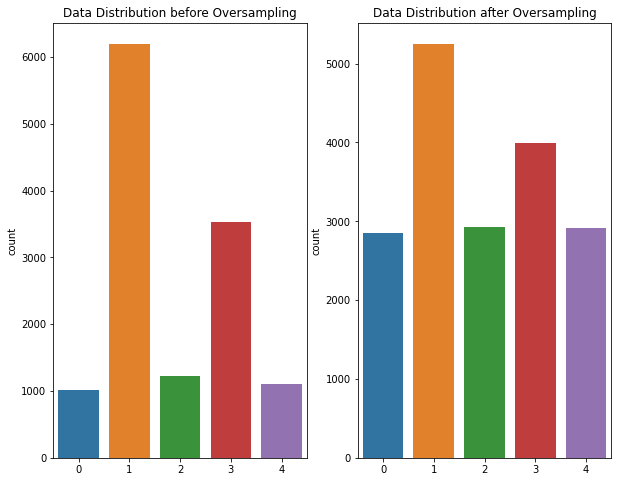

In [678]:
#Plotting the model before and after overampling

import seaborn as sns
plt.figure(figsize = (10, 8))
plt.subplot(1, 2, 1)
sns.countplot(category)
plt.title('Data Distribution before Oversampling')
plt.subplot(1, 2, 2)
sns.countplot(category_over)
plt.title('Data Distribution after Oversampling')
plt.show()

In [679]:
print(review_pad_over.shape)
print(category_over.shape)

(17930, 62)
(17930,)


##Transformer

In [598]:
EMBEDDING_DIM = 100
num_words = len(word_index) + 1

In [599]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding,SpatialDropout1D,GRU, RNN
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.initializers import Constant

In [600]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [601]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [602]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [603]:
embed_dim = EMBEDDING_DIM  # Embedding size for each token
vocab_size = 50000
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(max_length,))
embedding_layer = TokenAndPositionEmbedding(max_length, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(500, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(500, activation="relu")(x)
outputs = layers.Dense(count, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 62)]              0         
_________________________________________________________________
token_and_position_embedding (None, 62, 100)           5006200   
_________________________________________________________________
transformer_block_24 (Transf (None, 62, 100)           87632     
_________________________________________________________________
global_average_pooling1d_24  (None, 100)               0         
_________________________________________________________________
dropout_99 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_121 (Dense)            (None, 500)               50500     
_________________________________________________________________
dropout_100 (Dropout)        (None, 500)               0  

In [604]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001, name="Adam"), metrics=['accuracy'])
# history = model.fit(
#     x_train, y_train, batch_size=32, epochs=2, validation_data=(x_val, y_val)
# )
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001)
es = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)
history = model.fit(review_pad_over, category_over, epochs=35, batch_size=256, validation_data=(review_pad_test, category_test), callbacks=[reducelr])

Epoch 1/35
71/71 [==============================] - 6s 73ms/step - loss: 1.6232 - accuracy: 0.2047 - val_loss: 1.4887 - val_accuracy: 0.4543
Epoch 2/35
71/71 [==============================] - 5s 66ms/step - loss: 1.5719 - accuracy: 0.2872 - val_loss: 1.4393 - val_accuracy: 0.4543
Epoch 3/35
71/71 [==============================] - 5s 66ms/step - loss: 1.5552 - accuracy: 0.3087 - val_loss: 1.4270 - val_accuracy: 0.5452
Epoch 4/35
71/71 [==============================] - 5s 65ms/step - loss: 1.5413 - accuracy: 0.3263 - val_loss: 1.4064 - val_accuracy: 0.5588
Epoch 5/35
71/71 [==============================] - 5s 67ms/step - loss: 1.5254 - accuracy: 0.3499 - val_loss: 1.3790 - val_accuracy: 0.5772
Epoch 6/35
71/71 [==============================] - 5s 67ms/step - loss: 1.5029 - accuracy: 0.3674 - val_loss: 1.3495 - val_accuracy: 0.5781
Epoch 7/35
71/71 [==============================] - 5s 67ms/step - loss: 1.4790 - accuracy: 0.3895 - val_loss: 1.2922 - val_accuracy: 0.5786
Epoch 8/35
71

In [607]:
model.save_weights("transformer.h5")

###Plots
Plotting out the accuracy and loss of the model.

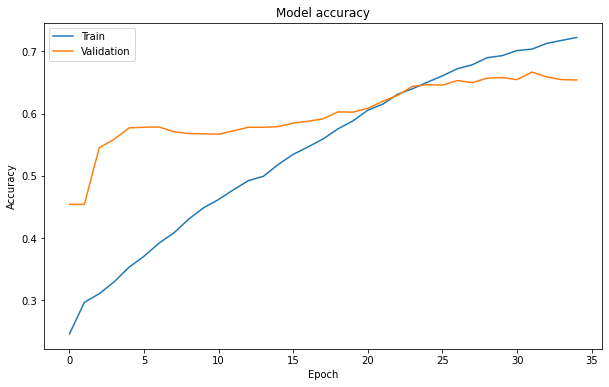

In [605]:
fig, axes = plt.subplots(1, figsize=(10, 6))

# Plot training & validation accuracy values

axes.plot(history.history['accuracy'])
axes.plot(history.history['val_accuracy'])
axes.set_title('Model accuracy')
axes.set_ylabel('Accuracy')
axes.set_xlabel('Epoch')
axes.legend(['Train', 'Validation'], loc='upper left')

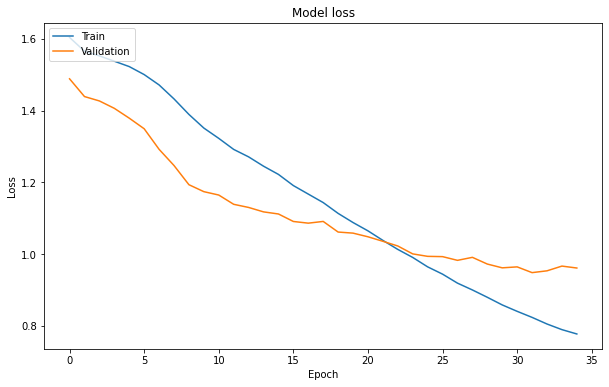

In [606]:
# Plot training & validation loss values

fig, axes = plt.subplots(1,1, figsize=(10, 6))

axes.plot(history.history['loss'])
axes.plot(history.history['val_loss'])
axes.set_title('Model loss')
axes.set_ylabel('Loss')
axes.set_xlabel('Epoch')
axes.legend(['Train', 'Validation'], loc='upper left')
plt.show()

##LSTM

In [689]:
EMBEDDING_DIM = 100
num_words = len(word_index) + 1

In [690]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding,SpatialDropout1D,GRU, RNN
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.initializers import Constant

In [691]:
model = Sequential()
model.add(Embedding(num_words, EMBEDDING_DIM, input_length=max_length))
model.add(tf.keras.layers.Bidirectional(LSTM(1000, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(LSTM(500)))
model.add(Dense(500, activation="relu"))
model.add(Dense(count, activation='softmax'))
model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_52 (Embedding)     (None, 62, 100)           2133100   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 62, 2000)          8808000   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 1000)              10004000  
_________________________________________________________________
dense_128 (Dense)            (None, 500)               500500    
_________________________________________________________________
dense_129 (Dense)            (None, 5)                 2505      
Total params: 21,448,105
Trainable params: 21,448,105
Non-trainable params: 0
_________________________________________________________________


In [692]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001, name="Adam"), metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001)
es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)
history = model.fit(review_pad_over, category_over, epochs=30, verbose=1, batch_size=256, validation_data=(review_pad_test, category_test), callbacks=[reduce_lr])

Epoch 1/30
71/71 [==============================] - 70s 895ms/step - loss: 1.6013 - accuracy: 0.2763 - val_loss: 1.4821 - val_accuracy: 0.4567
Epoch 2/30
71/71 [==============================] - 64s 901ms/step - loss: 1.5502 - accuracy: 0.3091 - val_loss: 1.2830 - val_accuracy: 0.5694
Epoch 3/30
71/71 [==============================] - 65s 911ms/step - loss: 1.4191 - accuracy: 0.4031 - val_loss: 1.2103 - val_accuracy: 0.5902
Epoch 4/30
71/71 [==============================] - 66s 924ms/step - loss: 1.3729 - accuracy: 0.4268 - val_loss: 1.2363 - val_accuracy: 0.5670
Epoch 5/30
71/71 [==============================] - 66s 931ms/step - loss: 1.3327 - accuracy: 0.4369 - val_loss: 1.2877 - val_accuracy: 0.5356
Epoch 6/30
71/71 [==============================] - 67s 949ms/step - loss: 1.3174 - accuracy: 0.4432 - val_loss: 1.1484 - val_accuracy: 0.5776
Epoch 7/30
71/71 [==============================] - 67s 944ms/step - loss: 1.2955 - accuracy: 0.4511 - val_loss: 1.1699 - val_accuracy: 0.5752

In [693]:
model.save_weights("lstm.h5")

###Plots
Plotting out the accuracy and loss of the model.

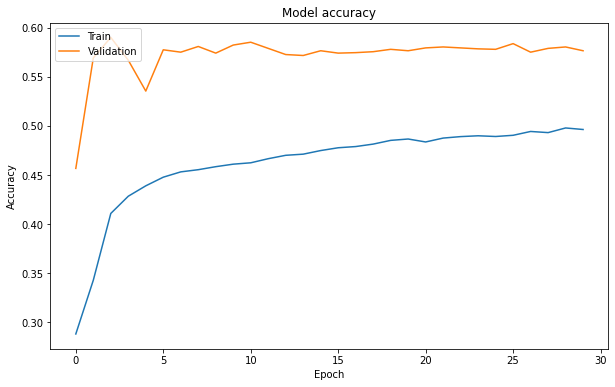

In [694]:
fig, axes = plt.subplots(1, figsize=(10, 6))

# Plot training & validation accuracy values

axes.plot(history.history['accuracy'])
axes.plot(history.history['val_accuracy'])
axes.set_title('Model accuracy')
axes.set_ylabel('Accuracy')
axes.set_xlabel('Epoch')
axes.legend(['Train', 'Validation'], loc='upper left')

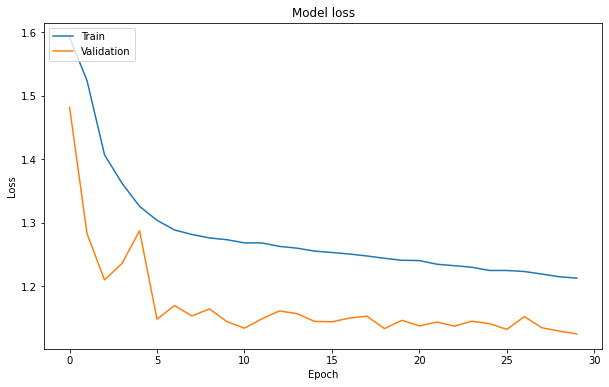

In [695]:
fig, axes = plt.subplots(1, figsize=(10, 6))

# Plot training & validation loss values

axes.plot(history.history['loss'])
axes.plot(history.history['val_loss'])
axes.set_title('Model loss')
axes.set_ylabel('Loss')
axes.set_xlabel('Epoch')
axes.legend(['Train', 'Validation'], loc='upper left')
plt.show()